In [1]:
import pdb
import time
import sys
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy.linalg import eig
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import datasets

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

sys.path.append('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/')
sys.path.append('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/utils_gfat')

from utils_gfat import quicklook_lidar, lidar, plot, solar, utils

Mounted at /content/drive


# funciones

In [2]:
def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, **kwargs):
  ds_ = ds.copy()
  ds_ = ds.assign_coords(range=ds.range/1000)
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  plot.title1('{instr} {mode} {qt} at {wl} {wlu}'.format(instr=attrs['system'],
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=2)
  plot.title2(str(ds_.time.values[0].astype('datetime64[D]')), coef=2)

  plot.title3('{} ({:.1f}N, {:.1f}E)'.format(attrs['site_location'], 
                                           float(attrs['geospatial_lat_min']), 
                                           float(attrs['geospatial_lon_min'])), coef=2)
  
  q = ds_[:, ds_.range<14].plot.pcolormesh(x='time', 
                 y='range', 
                 cmap=kwargs['cmap'], 
                 vmin=0, 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  myFmt = mdates.DateFormatter('%H:%M')
  axes.xaxis.set_major_formatter(myFmt)
  axes.tick_params(axis = 'both', which = 'major', labelsize = 14)
  axes.tick_params(axis = 'both', which = 'minor', labelsize = 14)
  plot.gapsizer(axes, ds_.time.values, ds_.range, gapsize=5, colour='#c7c7c7')
  axes.set_xlim([ds_.time[0].values.astype('datetime64[D]'), ds_.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  # q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds_.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)

def normalize_ds(ds_variable, operation='standar'):

  if ds_variable.shape[0] == 1:
    ds_ = np.reshape(ds_variable.copy(), ds_variable.shape[1])
  else:
    ds_ = ds_variable.copy()

  if operation == 'standar':
    # pdb.set_trace()
    mean = ds_.mean()
    std = ds_.std() 
    for idx, prof in enumerate(ds_):
      
      ds_[idx] = (prof - mean) / std 
  # pdb.set_trace()
  return ds_

def mahalanobis_transform(X):
  cov = np.cov(X, rowvar=False)

  eigenvalues, U = eig(cov)
  Q = eigenvalues * np.identity(cov.shape[0]) 

  gamma = X @ U.T

  std_gamma = np.std(gamma, axis=0)

  mat_ = (1 / std_gamma) * np.identity(cov.shape[0])

  Z = gamma @ mat_

  return Z



# MKmn (Día solo aerosol)

In [4]:
ds = xr.load_dataset('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/1a/20210709/mhc_rcs_20210709.nc')
rcs = ['corrected_rcs_00', 'corrected_rcs_01', 'corrected_rcs_02', 'corrected_rcs_03'] # 00 y 02 -> Analogico, 01 y 03 -> PC
signal = ['corrected_signal_00', 'corrected_signal_02']
ds

<xarray.Dataset>
Dimensions:                (range: 1333, time: 1395, nv: 2, n_chan: 2)
Coordinates:
  * range                  (range) float32 7.5 15.0 22.5 ... 9.99e+03 9.998e+03
  * time                   (time) datetime64[ns] 2021-07-09T00:00:42 ... 2021...
  * n_chan                 (n_chan) int32 0 2
Dimensions without coordinates: nv
Data variables: (12/48)
    time_bnds              (time, nv) datetime64[ns] 2021-07-09T00:00:42 ... ...
    lat                    float32 37.16
    lon                    float32 -3.61
    altitude               float32 680.0
    wavelength             (n_chan) float32 532.0 532.0
    telescope              (n_chan) int32 1 1
    ...                     ...
    corrected_rcs_02       (time, range) float64 157.4 292.1 ... -5.236e+04
    dc_smoothed_02         (time, range) float64 4.525 6.029 ... 7.317 7.317
    bin_zero               (n_chan) float64 0.0 0.0
    dead_time              (n_chan) float64 0.0 0.0
    total_rcs532_an        (time, range) float64 84.53 165.0 ... 9.496e+04
    LVDR532_an             (time, range) float64 0.4064 0.3667 ... 2.505 -0.2032
Attributes: (12/74)
    system:                          MULHACEN
    manufacturers:                   Raymetrics
    overlap_is_corrected:            false
    overlap_function:                false
    site_location:                   Granada, Spain
    instrument_id:                   MULHACEN
    ...                              ...
    telescope0_manufacturer:         Raymetrics
    telescope0_model:                special
    BCK_MIN_ALT:                     75000
    BCK_MAX_ALT:                     105000
    lidarNick:                       mhc
    dataversion:                     1a

In [5]:
time = '2021-07-09T06:48:16.000000000'
t_win = 3
media_std= ds[signal[0]].rolling(dim={'range':3, 'time':t_win}, min_periods=1).std().sel(range=slice(6000, 14000)).mean()
nstd = (ds[signal[0]].rolling(dim={'range':3, 'time':t_win}, min_periods=1).std() / media_std)#.values.ravel()
nstd

<xarray.DataArray 'corrected_signal_00' (time: 1395, range: 1333)>
array([[0.00000000e+00, 1.65593611e+02, 2.30411339e+02, ...,
        5.30307134e-01, 4.86201168e-01, 4.97077105e-01],
       [9.21974911e-01, 1.65478154e+02, 2.30015366e+02, ...,
        4.42421561e-01, 4.25526480e-01, 6.99318261e-01],
       [7.52794707e-01, 1.65305587e+02, 2.30031272e+02, ...,
        5.74510282e-01, 6.35916663e-01, 8.35895281e-01],
       ...,
       [8.39207642e-01, 1.65635014e+02, 2.30308729e+02, ...,
        3.58295042e-01, 4.20415662e-01, 4.34319035e-01],
       [9.86515054e-01, 1.65728251e+02, 2.30192131e+02, ...,
        5.86117818e-01, 6.96146774e-01, 8.19241329e-01],
       [1.72781649e-01, 1.65264847e+02, 2.29787712e+02, ...,
        6.16185413e-01, 7.01374833e-01, 8.27577177e-01]])
Coordinates:
  * range    (range) float32 7.5 15.0 22.5 30.0 ... 9.982e+03 9.99e+03 9.998e+03
  * time     (time) datetime64[ns] 2021-07-09T00:00:42 ... 2021-07-09T23:19:26

Verificar con varios perfiles y varios días.

In [48]:
# time = '2021-07-09T06:48:16.000000000'
# time = ds.time[0]
labels_ = np.empty(ds.corrected_rcs_00[0].shape, dtype=np.int8)

init_cluster = np.array([#[0, 0,0], 
                        [0, 0, ds.range.max()],
                        # [0, 0, Z[:,2].max()],
                        [0,0,0],
                        # [0, 0, Z[:,2].min()],
                        # [0, 0, ds.range.max()*(2/4)],
                        # [0, 0, ds.range.max()*(3/4)],
                        # [0, 0, ds.range.max()*(3.5/4)],
                        # [0, 0, ds.range.max()],
                        # [0,0,0]
                        [0, 0, ds.range.max()*(2/4)],
                        # [0, 0, Z[:,2].mean()],
                        ])

# for time in ds.time:
for time in ['2021-07-09T06:48:16.000000000']:
  # print(time.values)
  X = np.column_stack((ds.corrected_rcs_00.sel(time=time).values.ravel(), nstd.sel(time=time).values.ravel(), ds.range.values))

  # pdb.set_trace()
  X_norm = np.column_stack((normalize_ds(ds.corrected_rcs_00.sel(time=time).values), 
                            normalize_ds(nstd.sel(time=time).values), 
                            normalize_ds(ds.range.values) 
                            ))

  

  Z = mahalanobis_transform(X)


  scaler = preprocessing.StandardScaler().fit(X_norm)
  X_scaled = scaler.transform(X_norm)

  estimator = KMeans(n_clusters=3, init=init_cluster)


  estimator.fit(X_norm)
  labels = estimator.labels_

  labels_ = np.vstack((labels_, labels))

  init_cluster = estimator.cluster_centers_

labels_ = labels_[1:]
colors = ['red', 'blue', 'green', 'yellow', 'black']
colors = ['blue', 'red', 'yellow']

# ds = ds.assign(labels=labels)



In [37]:
# time = '2021-07-09T06:48:16.000000000'
# time = ds.time[0]
labels_ = np.empty(len(ds.time) * len(ds.range), dtype=np.int8)

init_cluster = np.array([#[0, 0,0], 
                        [0, 0, ds.range.max()],
                        [0,0,0],
                        # [0, 0, ds.range.max()*(2/4)],
                        # [0, 0, ds.range.max()*(3/4)],
                        # [0, 0, ds.range.max()*(3.5/4)],
                        # [0, 0, ds.range.max()],
                        # [0,0,0]
                        [0, 0, ds.range.max()*(2/4)],
                        ])



X = np.column_stack((ds.corrected_rcs_00.values.ravel(), nstd.values.ravel(), np.array([ds.range.values]*len(ds.time)).ravel()))

# X_norm = np.column_stack((normalize_ds(ds.corrected_rcs_00.sel(time=time).values), 
#                           normalize_ds(nstd.sel(time=time).values), 
#                           normalize_ds(ds.range.values) 
#                           ))



Z = mahalanobis_transform(X)

# pdb.set_trace()

scaler = preprocessing.StandardScaler().fit(Z)
X_scaled = scaler.transform(Z)

estimator = KMeans(n_clusters=3)


estimator.fit(Z)
labels = estimator.labels_

labels_ = np.vstack((labels_, labels))

init_cluster = estimator.cluster_centers_

labels_ = labels_[1:]
colors = ['red', 'blue', 'green', 'yellow', 'black']
colors = ['blue', 'red', 'yellow']
labels_ = labels_.reshape((ds.time.shape[0],ds.range.shape[0]))
# ds = ds.assign(labels=labels)



In [ ]:
labels_.shape


(1395, 1333)

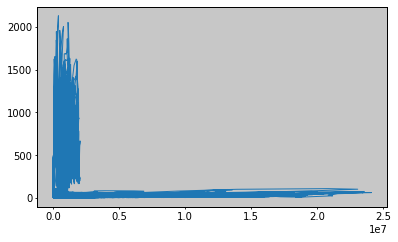

In [ ]:
# plt.plot(Z[:,0], Z[:, 1])
# plt.plot(ds.corrected_rcs_00[-1].values, ds.range)
plt.plot(X_norm[:,0], X_norm[:,1])

Text(0.5, 0, 'RCS [a.u]')

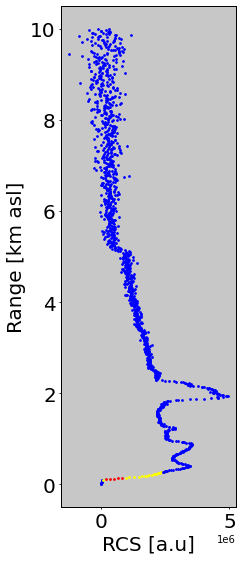

In [51]:
# pdb.set_trace()
colors = ['red', 'blue', 'yellow']
time = '2021-07-09T06:48:16.000000000'
fig = plt.figure(figsize=(3,10))

ds_ = ds.assign_coords(range=ds.range/1000)
for idx, lab in enumerate(labels):
  # pdb.set_trace()
  plt.scatter(ds_.corrected_rcs_00.sel(time=time, method='nearest').values[0][idx], ds_.range[idx], c=colors[lab], s=3)

# plt.title('Clasification of a profile mean Mahalanobis Transform.')
# plt.title('Clasification of a profile mean conventional Standarization.')
# plt.title('Clasification of a profile mean raw dataset.')

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.ylabel('Range [km asl]', fontsize=20)
plt.xlabel('RCS [a.u]', fontsize=20)

In [ ]:
ds = ds.assign(labels=(['time', 'range'], labels_))

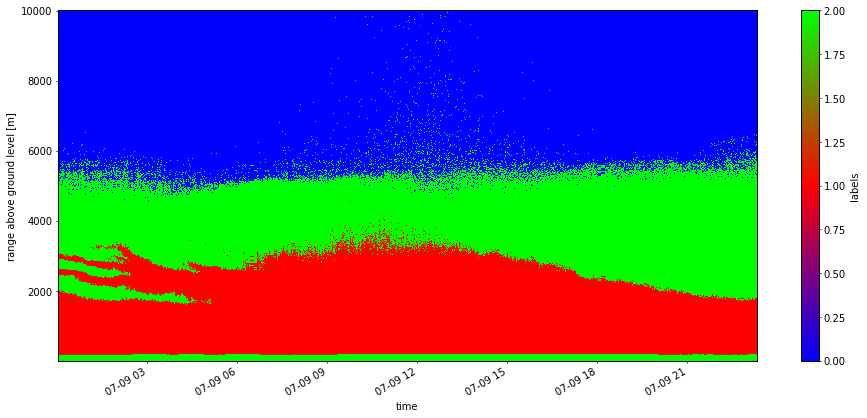

In [ ]:
fig = plt.figure(figsize=(15, 7))
ds.labels.plot.pcolormesh(x='time', cmap='brg')

No handles with labels found to put in legend.


KeyError: ignored

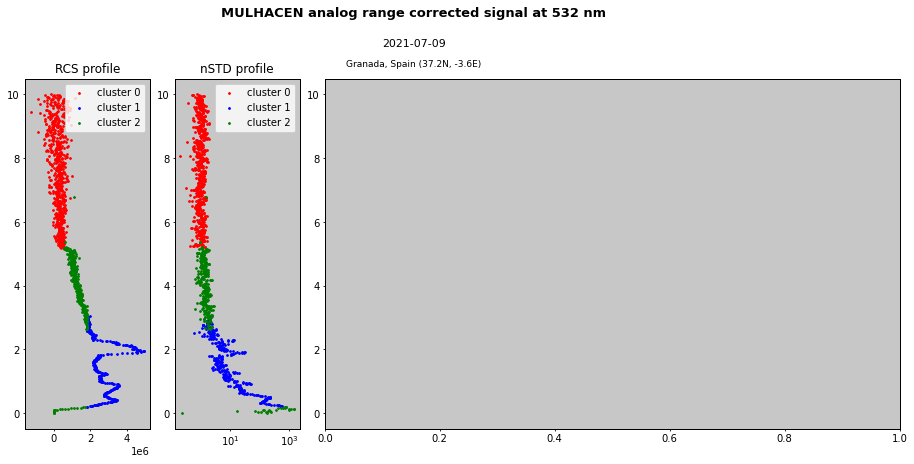

In [ ]:
qt = 'range corrected signal'
wl = '532'
signal_mode = 'analog'
channel = 'signal_532xpa'

for time in ['2021-07-09T06:48:16.000000000', '2021-07-09T03:47:14.000000000', '2021-07-09T16:38:16.000000000']:
  fig, ax = plt.subplots(figsize=[15,7])

  ax1 = plt.subplot(1,6,(1))

  
  # ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
  # ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

  ax1.legend(fontsize=10, loc='upper center')
  # pdb.set_trace()
  for lab in range(3):
    ax1.scatter(ds.corrected_rcs_00.sel(time=time, method='nearest')[0].values[np.where(ds.labels.sel(time=time).values[0]==lab)], ds.range[np.where(ds.labels.sel(time=time).values[0]==lab)]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
  ax1.legend(fontsize=10)
  ax1.set_title('RCS profile')

  ax1_2 = plt.subplot(1,6,(2), sharey=ax1)

  media_std= ds[signal[0]].rolling(dim={'range':3, 'time':t_win}, min_periods=3).std().sel(time=time, range=slice(6000, 10000))[0].mean()
  nstd = ds[signal[0]].rolling(dim={'range':3, 'time':t_win}, min_periods=3).std().sel(time=time, method='nearest')[0] / media_std 


  # ax1_2.plot(nstd.values, ds.range.values, lw=1, label='std[{t_win}mean] of signal at 532 nm'.format(t_win=t_win))
  # ax1_2.set_xlim(0.5, 2)
  for lab in range(3):
    ax1_2.scatter(nstd.values[np.where(ds.labels.sel(time=time).values[0]==lab)], ds.range[np.where(ds.labels.sel(time=time).values[0]==lab)]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
  ax1_2.legend(fontsize=10)
  ax1_2.set_xscale('log')
  ax1_2.set_title('nSTD profile')

  ax2 = plt.subplot(1,6,(3,6), sharey=ax1)
  
  plot_as_me(ds[rcs[0]], 
           channel, 
           ax2, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=4e6)


  
  # Create rectangle x coordinates
  startTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000')
  endTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000') + dt.timedelta(minutes=1)
  start = mpl.dates.date2num(startTime)
  end = mpl.dates.date2num(endTime)
  width = end - start
  rect = mpl.patches.Rectangle((start, 0), width, 10000, linewidth=3,color='red',fill=False)
  ax2.add_patch(rect)
  rect2 = mpl.patches.Rectangle((1, 0), 0.001, 10000, linewidth=2,color='red',fill=False)
  # ax1_2.add_patch(rect2)
  # rect3 = mpl.patches.Rectangle((1.46153563, 0), 0.001, 10000, linewidth=2,color='red',fill=False)
  # ax1_2.add_patch(rect3)
  ax2.set_ylabel('')
  ax1.set_ylabel('Height, km asl', fontsize=15)
  ax1.set_xlabel('[a.u]', fontsize=15)
  ax1_2.set_xlabel('[a.u]', fontsize=15)
  o_ = plt.setp(ax2.get_yticklabels(), visible=False)
  u_ = plt.setp(ax1_2.get_yticklabels(), visible=False)

  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
  # hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
  # minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


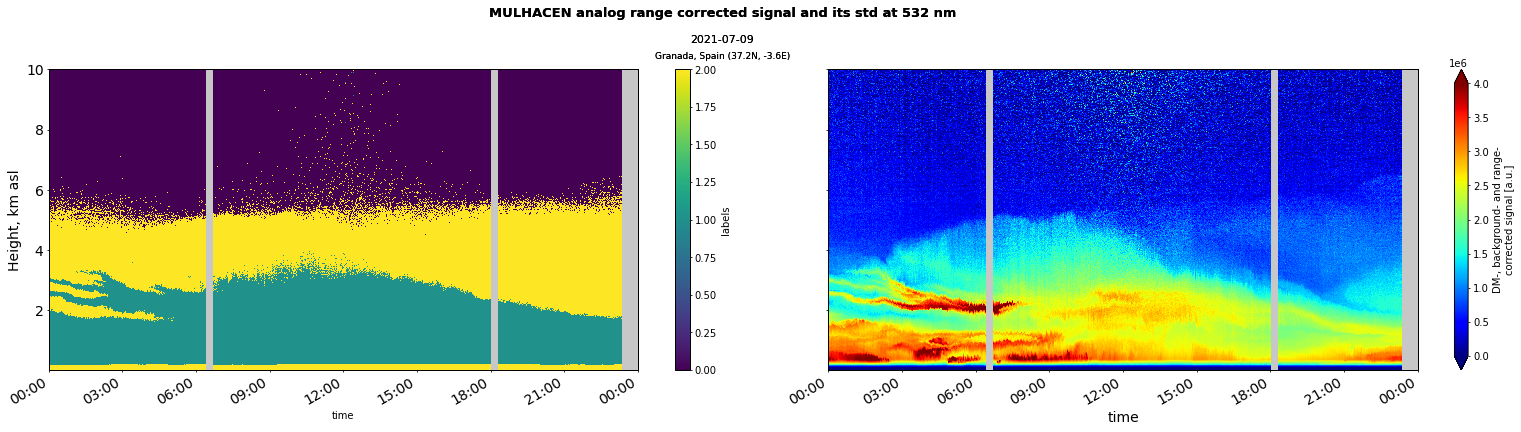

In [ ]:
qt = 'range corrected signal and its std'
wl = '532'
signal_mode = 'analog'
channel = 'signal_532xpa'

fig, ax = plt.subplots(figsize=[26,6])

ax1 = plt.subplot(1,6,(1,3))

ds_ = ds.copy()
ds_ = ds.assign_coords(range=ds.range/1000)
# ds_.labels.plot.pcolormesh(x='time')

cmap = mpl.cm.get_cmap('brg', 3)

plot_as_me(ds.labels, 
           'labels', 
           ax1, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=None,
           cmap=None)


ax2 = plt.subplot(1,6,(4,15), sharey=ax1)



plot_as_me(ds[rcs[0]], 
           channel, 
           ax2, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=4e6,
           cmap='jet')


ax2.set_ylabel('')
ax1.set_ylabel('Height, km asl', fontsize=14)
ax2.set_xlabel('time', fontsize=14)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_, visible=False)




# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

In [ ]:
iris = datasets.load_iris()
iris['data']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fignum = 1
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

# for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
#     ax.text3D(
#         X[y == label, 3].mean(),
#         X[y == label, 0].mean(),
#         X[y == label, 2].mean() + 2,
#         name,
#         horizontalalignment="center",
#         bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
#     )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
# ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")
pdb.set_trace()
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=ds.labels.values[0], edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")
ax.dist = 12

fig.show()

# MKmn (Día con nubes)

In [3]:
ds = lidar.preprocessing(rs_fl='/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Datos/MULHACEN/20211111/*Prs*.nc', 
                             dc_fl='/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Datos/MULHACEN/20211111*Pdc*.nc', 
                             channels='all').sel(range=slice(0, 14000))

INFO: lidar. preprocessing. L441: Start Lidar Preprocessing ...
INFO: lidar. preprocessing. L444: Read Raw Signal
INFO: lidar. reader_xarray. L251: Start Reader ...
INFO: lidar. reader_xarray. L262: ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Datos/MULHACEN/20211111/mhc_1a_Prs_rs_xf_20211111.nc']
INFO: lidar. reader_xarray. L354: End Reader
INFO: lidar. preprocessing. L482: Read DC Signal
INFO: lidar. reader_xarray. L251: Start Reader ...
INFO: lidar. reader_xarray. L354: End Reader
INFO: lidar. preprocessing. L513: Channel 532xpa
INFO. Start Get Bin Zero
WARNING. Data directory /mnt/NASGFAT/datos not found
bin zero info will not be reached
Error. File False not found
INFO. End Get Bin Zero
Start Analog Preprocessing
Start Estimate Background
End Estimate Background
End Analog Preprocessing
INFO: lidar. preprocessing. L513: Channel 532xpp
INFO. Start Get Bin Zero
WARNING. Data directory /mnt/NASGFAT/datos not found
bin zero info will not be reached
Error. File False not found
INFO.

In [ ]:
ds

<class 'numpy.ndarray'>


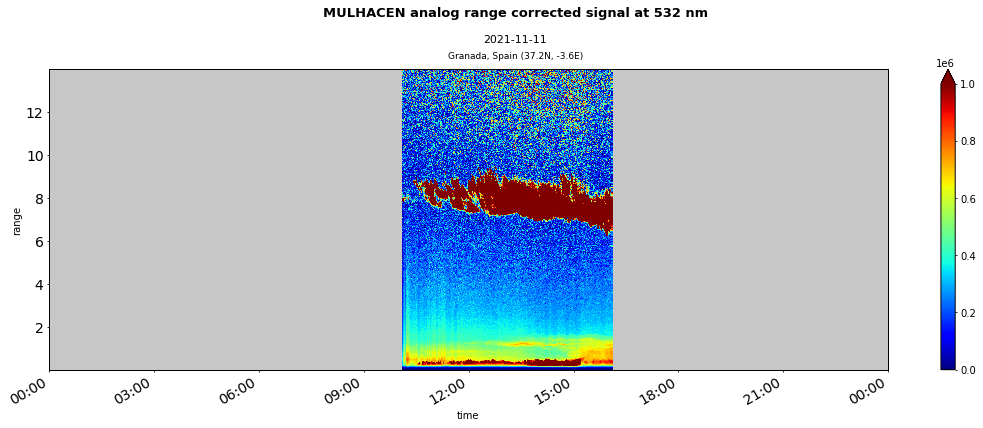

In [ ]:
qt = 'range corrected signal'
wl = '532'
signal_mode = 'analog'
channel = 'signal_532xta'
fig, axes = plt.subplots(nrows=1, figsize=(18,6))

plot_as_me(ds[channel] * ds.range**2, channel, axes, qt, wl, signal_mode, attrs=ds.attrs, vmax=1e6, cmap='jet')


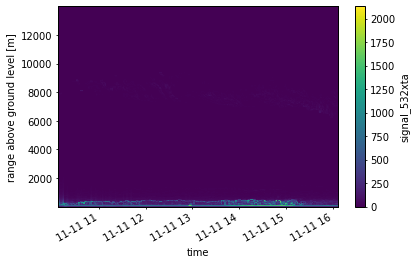

In [ ]:
# time = '2021-07-09T06:48:16.000000000'
t_win = 3
media_std= ds.signal_532xta.rolling(dim={'range':3, 'time':t_win}, min_periods=1).std().sel(range=slice(10000, 14000)).mean()
nstd = (ds.signal_532xta.rolling(dim={'range':3, 'time':t_win}, min_periods=1).std().sel(range=slice(0, 14000)) / media_std)#.values.ravel()
nstd.plot.pcolormesh(x='time', vmax=None)

Verificar con varios perfiles y varios días.

In [ ]:
# time = '2021-07-09T06:48:16.000000000'
# time = ds.time[0]
n_clusters = 4

labels_ = np.empty(ds.signal_532xta[0].shape, dtype=np.int8)

X0 = np.column_stack((rcs[0], nstd_[0], ds.range.values))
Z0 = mahalanobis_transform(X0)

# init_cluster = np.array([#[0, 0,0], 
#                         [0, 0, Z0[:,2].max()],
#                         # [0,0,0],
#                         [0, 0, Z0[:,2].max()*(2/4)],
#                         [0, 0, Z0[:,2].max()*(3/4)],
#                         # [0, 0, ds.range.max()*(3.5/4)],
#                         # [0, 0, ds.range.max()],
#                         [0, 0, Z0[:,2].min()]
#                         # [0, 0, ds.range.max()*(2/4)],
#                         ])

init_cluster = np.array([#[0, 0,0], 
                        [0, 0, normalize_ds(ds.range.values).max()],
                        # [0,0,0],
                        [0, 0, normalize_ds(ds.range.values).max()*(2/4)],
                        [0, 0, normalize_ds(ds.range.values).max()*(3/4)],
                        # [0, 0, ds.range.max()*(3.5/4)],
                        # [0, 0, ds.range.max()],
                        [0,0,0]
                        # [0, 0, ds.range.max()*(2/4)],
                        ])
rcs = (ds.signal_532xta * ds.range**2).values
nstd_ = nstd.values

for tim in range(len(ds.time)):

  # pdb.set_trace()
  # t0 = time.time()
  X = np.column_stack((rcs[tim], nstd_[tim], ds.range.values))
  # pdb.set_trace()
  X_norm = np.column_stack((normalize_ds(rcs[tim]), 
                            normalize_ds(nstd_[tim]),
                            normalize_ds(ds.range.values) 
                            ))

  
  # t1 = time.time()
  # X_norm = mahalanobis_transform(X)

  # t2 = time.time()
  scaler = preprocessing.StandardScaler().fit(X_norm)
  X_scaled = scaler.transform(X_norm)

  estimator = KMeans(n_clusters=n_clusters, init=init_cluster, n_init=10)


  estimator.fit(X_norm)
  labels = estimator.labels_

  labels_ = np.vstack((labels_, labels))

  init_cluster = estimator.cluster_centers_
  # t3 = time.time()
  # print('X: ', t1-t0, ', Z: ', t2-t1, ', model: ', t3-t2)
labels_ = labels_[1:]
colors = ['red', 'blue', 'green', 'yellow', 'black']

# ds = ds.assign(labels=labels)



In [ ]:
# time = '2021-07-09T06:48:16.000000000'
# time = ds.time[0]
n_clusters = 4

labels_ = np.empty(len(ds.time) * len(ds.range), dtype=np.int8)

# X0 = np.column_stack((rcs[0], nstd_[0], ds.range.values))
# Z0 = mahalanobis_transform(X0)

# init_cluster = np.array([#[0, 0,0], 
#                         [0, 0, Z0[:,2].max()],
#                         # [0,0,0],
#                         [0, 0, Z0[:,2].max()*(2/4)],
#                         [0, 0, Z0[:,2].max()*(3/4)],
#                         # [0, 0, ds.range.max()*(3.5/4)],
#                         # [0, 0, ds.range.max()],
#                         [0, 0, Z0[:,2].min()]
#                         # [0, 0, ds.range.max()*(2/4)],
#                         ])

init_cluster = np.array([#[0, 0,0], 
                        [0, 0, normalize_ds(ds.range.values).max()],
                        # [0,0,0],
                        [0, 0, normalize_ds(ds.range.values).max()*(2/4)],
                        [0, 0, normalize_ds(ds.range.values).max()*(3/4)],
                        # [0, 0, ds.range.max()*(3.5/4)],
                        # [0, 0, ds.range.max()],
                        [0,0,0]
                        # [0, 0, ds.range.max()*(2/4)],
                        ])

rcs = (ds.signal_532xta * ds.range**2).values
nstd_ = nstd.values


# pdb.set_trace()
# t0 = time.time()
X = np.column_stack((rcs.ravel(), nstd_.ravel(),  np.array([ds.range.values]*len(ds.time)).ravel()))
# pdb.set_trace()
X_norm = np.column_stack((X[:,0], 
                          X[:,1],
                          X[:,2] 
                          ))


# t1 = time.time()
Z = mahalanobis_transform(X)

# t2 = time.time()
scaler = preprocessing.StandardScaler().fit(X_norm)
X_scaled = scaler.transform(X_norm)

estimator = KMeans(n_clusters=n_clusters, n_init=10)


estimator.fit(X_norm)
labels = estimator.labels_

labels_ = np.vstack((labels_, labels))

# t3 = time.time()
# print('X: ', t1-t0, ', Z: ', t2-t1, ', model: ', t3-t2)
labels_ = labels_[1:]

labels_ = labels_.reshape((ds.time.shape[0],ds.range.shape[0]))

colors = ['red', 'blue', 'green', 'yellow', 'black']

# ds = ds.assign(labels=labels)



In [ ]:
labels_.shape

(364, 1866)

In [ ]:
# plt.plot(Z[:,0], Z[:, 1])
# plt.plot(ds.corrected_rcs_00[-1].values, ds.range)
plt.plot(X_norm[:,0], X_norm[:,1])

ValueError: ignored

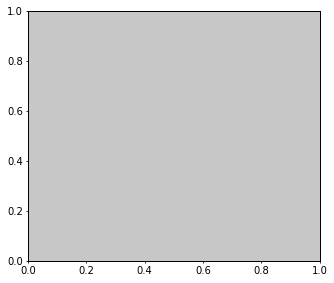

In [ ]:
# pdb.set_trace()

fig = plt.figure(figsize=(5,5))
for idx, lab in enumerate(labels):
  # pdb.set_trace()
  plt.scatter(ds.corrected_rcs_00.sel(time=time, method='nearest').values[idx], ds.range[idx], c=colors[lab], s=3)

# plt.title('Clasification of a profile mean Mahalanobis Transform.')
# plt.title('Clasification of a profile mean conventional Standarization.')
# plt.title('Clasification of a profile mean raw dataset.')
plt.ylabel('Range')
plt.xlabel('RCS [a.u]')

In [ ]:
ds = ds.assign(labels=(['time', 'range'], labels_))

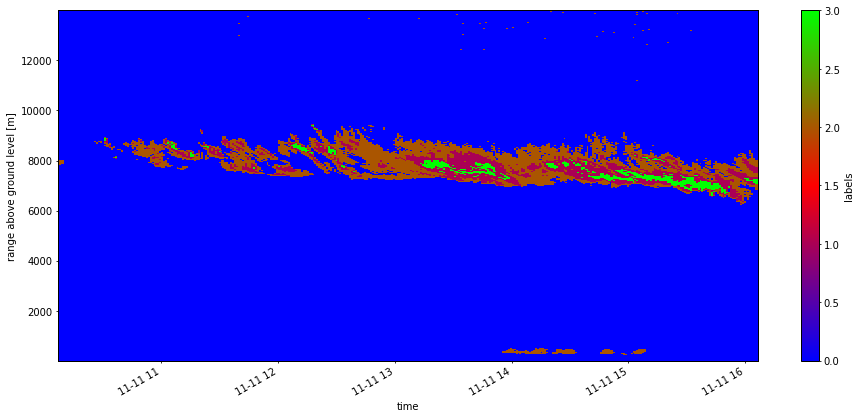

In [ ]:
fig = plt.figure(figsize=(15, 7))
ds.labels.plot.pcolormesh(x='time', cmap='brg')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<class 'numpy.ndarray'>


No handles with labels found to put in legend.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


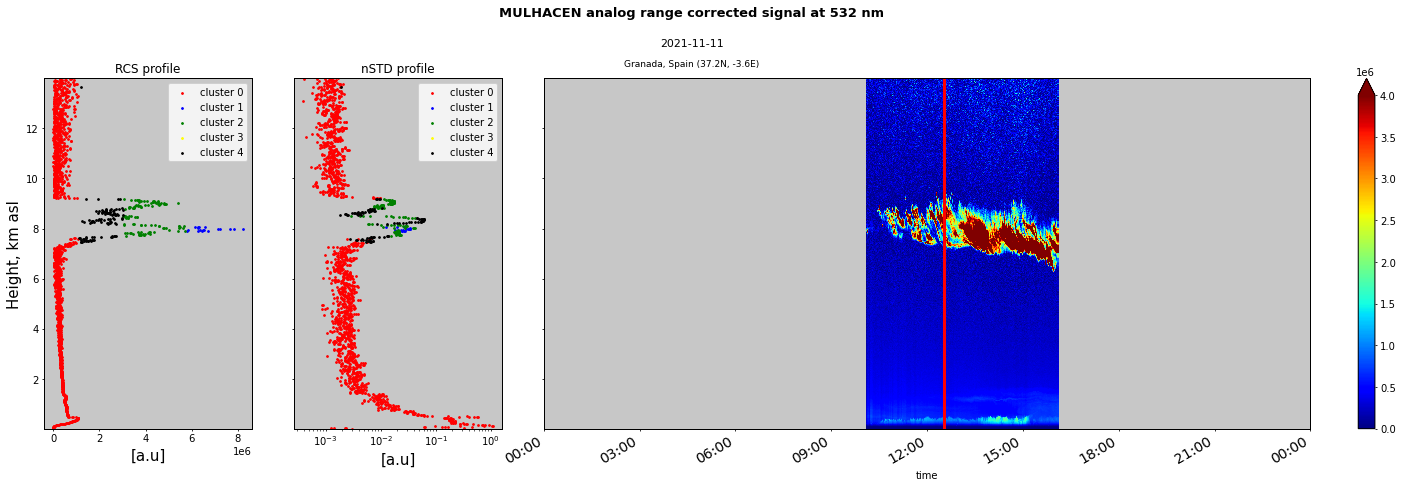

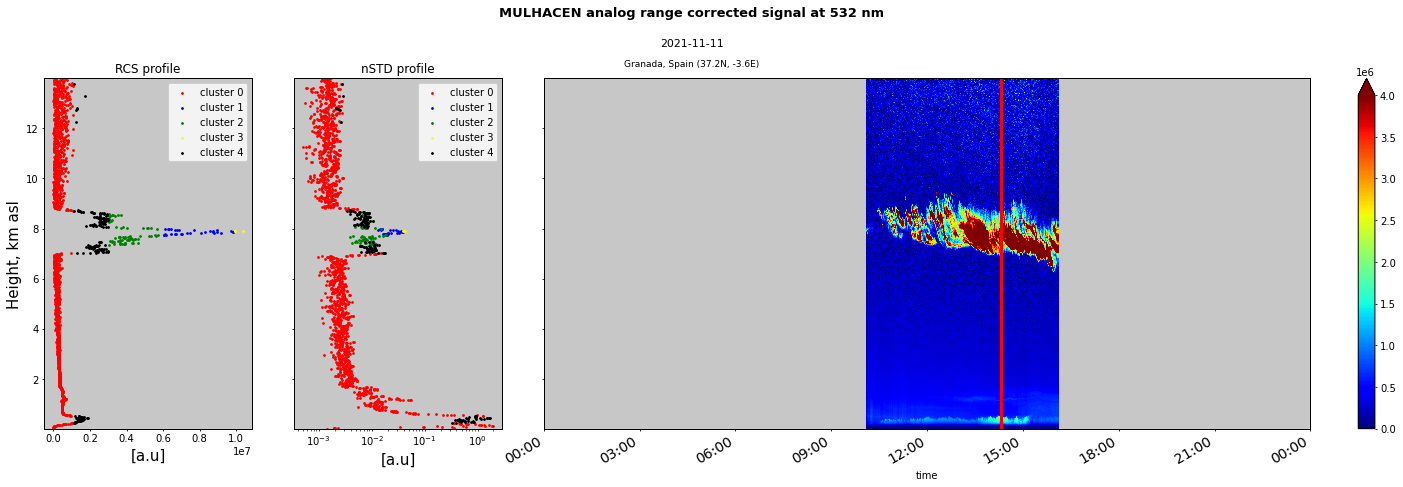

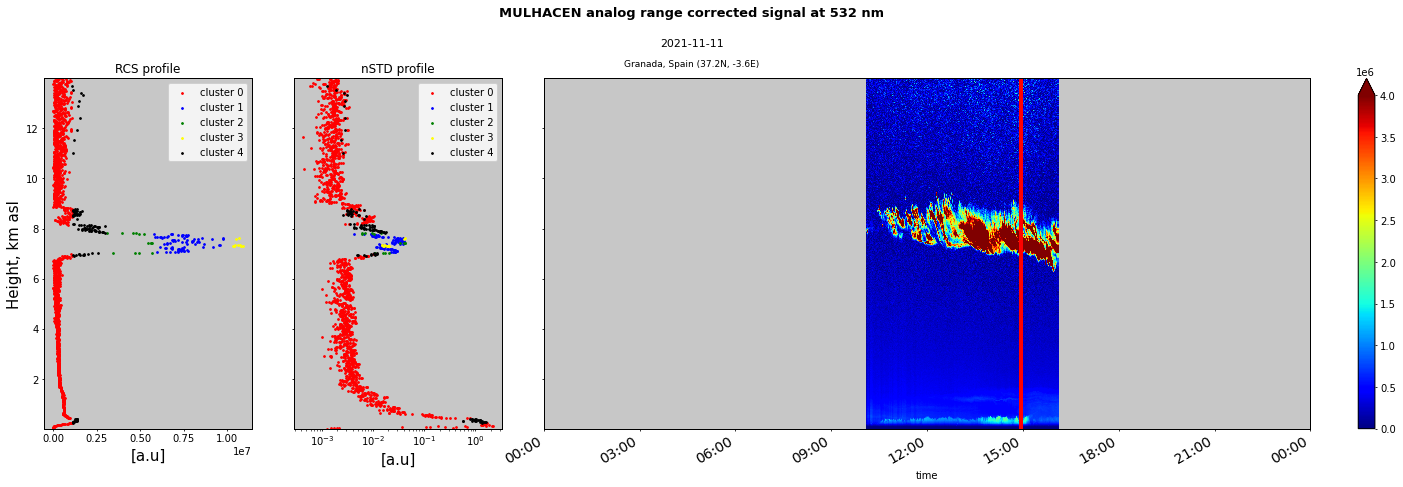

In [ ]:
qt = 'range corrected signal'
wl = '532'
signal_mode = 'analog'
channel = 'signal_532xpa'

for time in [np.datetime_as_string(ds.time[int(len(ds.time)*(2/5))].values), np.datetime_as_string(ds.time[int(len(ds.time)*(3.5/5))].values), np.datetime_as_string(ds.time[int(len(ds.time)*(4/5))].values)]:#, '2021-07-09T03:47:14.000000000', '2021-07-09T16:38:16.000000000']:
  fig, ax = plt.subplots(figsize=[25,7])

  ax1 = plt.subplot(1,6,(1))

  
  # ax1.plot(ds[rcs[0]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='b', label='rcs profile at 532 nm')
  # ax1.plot(ds[rcs[1]].sel(time=time, method='nearest')[0].values, ds.range.values, lw=2, c='r', label='rcs profile at 1064 nm')

  ax1.legend(fontsize=10, loc='upper center')
  # pdb.set_trace()
  for lab in range(n_clusters):
    ax1.scatter((ds.signal_532xta*ds.range**2).sel(time=time, method='nearest').values[np.where(ds.labels.sel(time=time).values==lab)], ds.range[np.where(ds.labels.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
  ax1.legend(fontsize=10)
  ax1.set_title('RCS profile')

  ax1_2 = plt.subplot(1,6,(2), sharey=ax1)

  # pdb.set_trace()
  # media_std = ds.signal_532xta.rolling(dim={'range':3, 'time':t_win}, min_periods=3).std().sel(time=time, range=slice(8000, 14000)).mean()
  media_std = 1
  nstd = ds.signal_532xta.rolling(dim={'range':3, 'time':t_win}, min_periods=3).std().sel(time=time, method='nearest') / media_std 


  # ax1_2.plot(nstd.values, ds.range.values, lw=1, label='std[{t_win}mean] of signal at 532 nm'.format(t_win=t_win))
  # ax1_2.set_xlim(0.5, 2)

  # pdb.set_trace()
  for lab in range(n_clusters):
    ax1_2.scatter(nstd.values[np.where(ds.labels.sel(time=time).values==lab)], ds.range[np.where(ds.labels.sel(time=time).values==lab)[1]]/1000, c=colors[lab], s=3, label='cluster {}'.format(lab))
  ax1_2.legend(fontsize=10)
  ax1_2.set_xscale('log')
  ax1_2.set_title('nSTD profile')

  ax2 = plt.subplot(1,6,(3,6), sharey=ax1)
  
  # pdb.set_trace()
  plot_as_me(ds.signal_532xta*ds.range**2, 
           channel, 
           ax2, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=4e6,
           cmap='jet'
           )


  # Create rectangle x coordinates
  startTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000')
  endTime = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000') + dt.timedelta(minutes=1)
  start = mpl.dates.date2num(startTime)
  end = mpl.dates.date2num(endTime)
  width = end - start
  rect = mpl.patches.Rectangle((start, 0), width, 10000, linewidth=3,color='red',fill=False)
  ax2.add_patch(rect)
  rect2 = mpl.patches.Rectangle((1, 0), 0.001, 10000, linewidth=2,color='red',fill=False)
  # ax1_2.add_patch(rect2)
  # rect3 = mpl.patches.Rectangle((1.46153563, 0), 0.001, 10000, linewidth=2,color='red',fill=False)
  # ax1_2.add_patch(rect3)
  ax2.set_ylabel('')
  ax1.set_ylabel('Height, km asl', fontsize=15)
  ax1.set_xlabel('[a.u]', fontsize=15)
  ax1_2.set_xlabel('[a.u]', fontsize=15)
  o_ = plt.setp(ax2.get_yticklabels(), visible=False)
  u_ = plt.setp(ax1_2.get_yticklabels(), visible=False)

  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-')
  # hour = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').hour
  # minute = dt.datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.000000000').minute
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_with_profile at_{hour}{minute}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, hour=hour, minute=minute, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


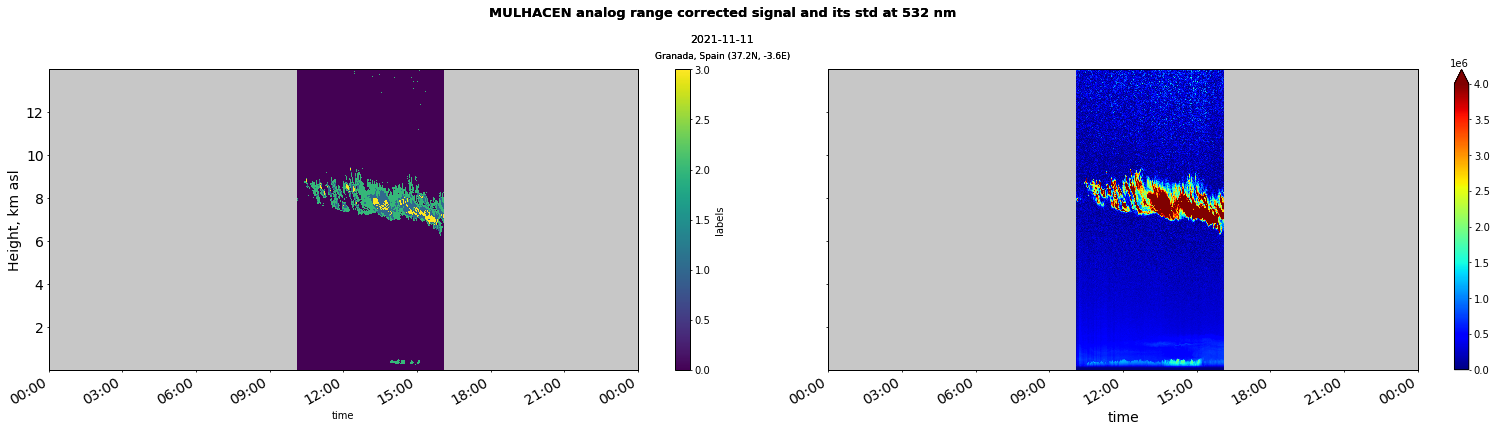

In [ ]:
qt = 'range corrected signal and its std'
wl = '532'
signal_mode = 'analog'
channel = 'signal_532xpa'

fig, ax = plt.subplots(figsize=[26,6])

ax1 = plt.subplot(1,6,(1,3))

ds_ = ds.copy()
ds_ = ds.assign_coords(range=ds.range/1000)
# ds_.labels.plot.pcolormesh(x='time')

cmap = mpl.cm.get_cmap('brg', 3)

plot_as_me(ds.labels, 
           'labels', 
           ax1, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=None,
           cmap=None)


ax2 = plt.subplot(1,6,(4,15), sharey=ax1)



plot_as_me(ds.signal_532xta*ds.range**2, 
           channel, 
           ax2, 
           qt, 
           wl, 
           signal_mode, 
           attrs=ds.attrs, 
           vmax=4e6,
           cmap='jet')


ax2.set_ylabel('')
ax1.set_ylabel('Height, km asl', fontsize=14)
ax2.set_xlabel('time', fontsize=14)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
# u_ = plt.setp(ax1.get_, visible=False)




# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

In [ ]:
iris = datasets.load_iris()
iris['data']

--Return--
> <ipython-input-169-27616ee7be6e>(59)<module>()->None
-> pdb.set_trace()
(Pdb) c


ValueError: ignored

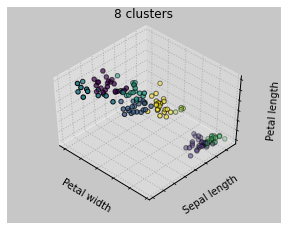

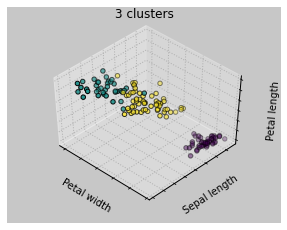

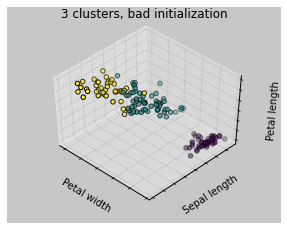

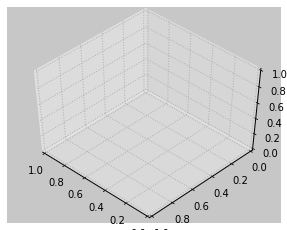

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fignum = 1
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

# for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
#     ax.text3D(
#         X[y == label, 3].mean(),
#         X[y == label, 0].mean(),
#         X[y == label, 2].mean() + 2,
#         name,
#         horizontalalignment="center",
#         bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
#     )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
# ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")
pdb.set_trace()
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=ds.labels.values[0], edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")
ax.dist = 12

fig.show()